In [1]:
# ! pip install pillow


In [2]:
# ! pip install diffusers transformers tokenizers==0.20.1 accelerate==1.0.1 safetensors==0.4.5 huggingface_hub==0.25.2


In [3]:
# ! pip install opencv-python scikit-image pandas 

In [4]:
import torch, platform
print("PyTorch:", torch.__version__, "CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))


PyTorch: 2.8.0+cu128 CUDA: 12.8
CUDA available: True
Device: NVIDIA GeForce RTX 5060 Ti


### Environment, paths, listing 

In [ ]:
import os, sys, random, math, time, gc
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# List a few files to confirm mounts
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames[:2]:
#         print(os.path.join(dirname, filename))

# I/O paths
WIKIART_ROOT = "E:/wikiart_dataset"
TEST_IMAGE = "E:/wikiart_dataset/High_Renaissance/andrea-del-sarto_archangel-raphael-with-tobias-st-lawrence-and-the-donor-leonardo-di-lorenzo-morelli-1512.jpg"
OUT_DIR = "E:/image_watermarking/out"
os.makedirs(OUT_DIR, exist_ok=True)


Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
PyTorch: 2.8.0+cu128
CUDA available: True


### Initialization and Watermark image creation based on artist's name

In [ ]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


IMG_SIZE = 256      # 256 for quick testing, 512 for final

# Training hyperparameters
BATCH_SIZE = 8
LR = 1e-3
EPOCHS = 200  # increase (50-200) for paper-level strength
PERT_BOUND= 10.0/255.0  # c in paper
ALPHA = 1.0              # GAN weight
BETA  = 10.0            # perturbation loss weight
W_WM  = 4.0              # inside-watermark weighting

def to_tensor(pil_img):
    return transforms.ToTensor()(pil_img)

    
def from_tensor(t):
    """
    Converts a [C,H,W] tensor in [0,1] to a PIL image.
    Handles both RGB (3ch) and grayscale (1ch) correctly.
    """
    t = t.detach().cpu().clamp(0,1)
    if t.ndim == 3 and t.shape[0] == 1:
        t = t.repeat(3,1,1)   # convert 1→3 channel for visualization
    arr = (t.permute(1,2,0).numpy() * 255).astype(np.uint8)
    return Image.fromarray(arr)


import os, random
from pathlib import Path
from collections import defaultdict
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

def load_rgb(path, size=None):
    img = Image.open(path).convert("RGB")
    if size:
        img = img.resize((size, size), Image.LANCZOS)
    return img



from PIL import Image, ImageDraw, ImageFont

def make_text_watermark(text="SISKIND", size=(512, 512), num_repetitions=9, font_name=None):
    W, H = size
    img = Image.new("L", (W, H), color=0)
    draw = ImageDraw.Draw(img)

    # --- Pick font ---
    font_paths = [
        "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",
        "C:/Windows/Fonts/arialbd.ttf",
        "/Library/Fonts/Arial Bold.ttf"
    ]
    if font_name:
        font_paths.insert(0, font_name)

    font = None
    for fp in font_paths:
        try:
            font = ImageFont.truetype(fp, 100)
            # print(f"Loaded font: {fp}")
            break
        except:
            continue
    if font is None:
        print("⚠️ Using default font")
        font = ImageFont.load_default()

    # --- Auto-fit font to width ---
    fs = 15
    while True:
        font = ImageFont.truetype(font.path if hasattr(font, 'path') else font_paths[0], fs)
        try:
            bbox = draw.textbbox((0, 0), text, font=font)
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
        except AttributeError:
            # For older Pillow
            w, h = draw.textsize(text, font=font)
        if w >= W * 0.95:
            break
        fs += 4
        if fs > 400:
            break

    # --- Draw repeated rows ---
    step = int(h * 1.2)
    y = 0
    while y < H:
        draw.text((0, y), text, fill=255, font=font)
        y += step

    return img.point(lambda p: 255 if p > 1 else 0).convert("1")




def show2(a, b, ta="A", tb="B", figsize=(8,4)):
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1); plt.imshow(a); plt.title(ta); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(b); plt.title(tb); plt.axis("off")
    plt.show()


In [7]:
wm = make_text_watermark("BEATTIE", size=(256,256))
wm.show()


### Load the VAE

In [8]:
# --- Block: Load Stable Diffusion v1.5 VAE (for L_adv) ---
from diffusers import AutoencoderKL
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# This will automatically download from Hugging Face if allowed,
# or you can use a Kaggle dataset containing 'runwayml/stable-diffusion-v1-5'
MODEL_PATH = "runwayml/stable-diffusion-v1-5"

VAE = AutoencoderKL.from_pretrained(
    MODEL_PATH,
    subfolder="vae",
    torch_dtype=torch.float32
).to(DEVICE)

VAE.eval()
for p in VAE.parameters():
    p.requires_grad_(False)

print("✅ Loaded Stable Diffusion v1.5 VAE (AutoencoderKL)")


c:\Users\User\anaconda3\envs\torch310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Loaded Stable Diffusion v1.5 VAE (AutoencoderKL)


### Dataset 

In [9]:
class WikiArtDataset(Dataset):
    """
    - Extract artist name from filename: e.g. 'basil-beattie_xxx.jpg' -> 'BEATTIE'
    - Create repeated watermark from that artist name
    - Return (image_tensor, watermark_tensor, image_path)
    """
    def __init__(self, image_paths, img_size=256):
        self.paths = image_paths
        self.img_size = img_size
        self.t = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

        # Precompute per-artist watermarks
        self.wm_cache = {}
        print(f"✅ Initialized dataset with {len(self.paths)} images.")

    def extract_artist_name(self, filename):
        # Format: "basil-beattie_untitled-xxx.jpg" → "BEATTIE"
        name = Path(filename).stem.split("_")[0]
        last = name.split("-")[-1]
        return last.upper()

    def __getitem__(self, i):
        img_path = self.paths[i]
        img = load_rgb(img_path, self.img_size)
        artist = self.extract_artist_name(os.path.basename(img_path))

        # Cache watermarks so we don’t regenerate for every sample
        if artist not in self.wm_cache:
            wm = make_text_watermark(artist, size=(self.img_size, self.img_size))
            self.wm_cache[artist] = to_tensor(wm)
        wm_tensor = self.wm_cache[artist]

        return self.t(img), wm_tensor, str(img_path)

    def __len__(self):
        return len(self.paths)

In [10]:
def build_wikiart_dataset(root_dir, img_size=256, artists_limit=50, train_per_artist=10):
    """
    root_dir: path to wikiart root (contains genre folders)
    """
    print("🔍 Scanning WikiArt folders...")
    all_imgs = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
        all_imgs += list(Path(root_dir).rglob(ext))

    artist_to_imgs = defaultdict(list)
    for p in all_imgs:
        fname = os.path.basename(p)
        if "_" not in fname:
            continue
        artist = fname.split("_")[0]
        artist_to_imgs[artist].append(p)

    # Filter to artists with enough images
    valid_artists = [a for a, v in artist_to_imgs.items() if len(v) >= train_per_artist + 1]
    random.shuffle(valid_artists)
    selected_artists = valid_artists[:artists_limit]

    print(f"✅ Selected {len(selected_artists)} artists (≥{train_per_artist}+ images each)")

    train_paths, val_paths = [], []
    for artist in selected_artists:
        imgs = artist_to_imgs[artist]
        random.shuffle(imgs)
        train_paths += imgs[:train_per_artist]
        val_paths += imgs[train_per_artist:]

    print(f"Training: {len(train_paths)}  |  Validation: {len(val_paths)}")

    train_ds = WikiArtDataset(train_paths, img_size=img_size)
    val_ds   = WikiArtDataset(val_paths, img_size=img_size)
    return train_ds, val_ds

In [11]:
from torch.utils.data import DataLoader

WIKIART_ROOT = r"E:\wikiart_dataset"
IMG_SIZE = 256
BATCH_SIZE = 8

# --- Build datasets ---
train_ds, val_ds = build_wikiart_dataset(
    WIKIART_ROOT,
    img_size=IMG_SIZE,
    artists_limit=50,
    train_per_artist=10
)

# --- DataLoaders ---
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"✅ Loaded {len(train_ds)} training samples and {len(val_ds)} validation samples.")



🔍 Scanning WikiArt folders...
✅ Selected 50 artists (≥10+ images each)
Training: 500  |  Validation: 4416
✅ Initialized dataset with 500 images.
✅ Initialized dataset with 4416 images.
✅ Loaded 500 training samples and 4416 validation samples.


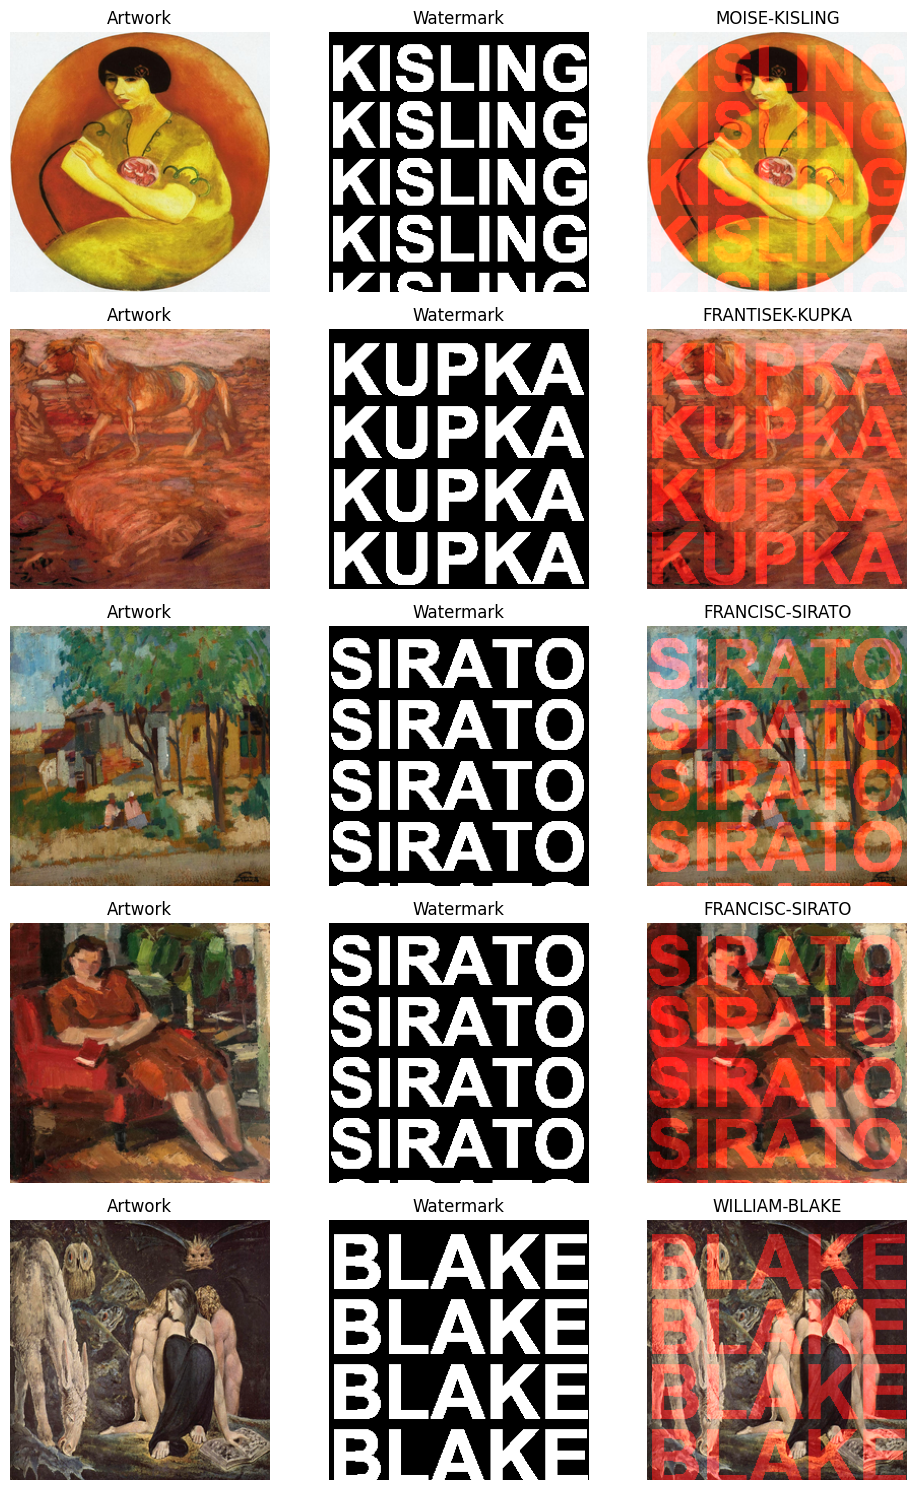

In [12]:
import matplotlib.pyplot as plt
import random
import torch

def show_sanity_samples(dataset, n=5):
    """
    Show random (image, watermark) pairs from dataset
    """
    idxs = random.sample(range(len(dataset)), min(n, len(dataset)))
    fig, axes = plt.subplots(n, 3, figsize=(10, 3*n))

    for i, idx in enumerate(idxs):
        img_t, wm_t, path = dataset[idx]
        img = img_t.permute(1, 2, 0).numpy()
        wm  = wm_t.squeeze().numpy()

        # normalize image for display
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        # overlay watermark on top of image (red tint)
        overlay = img.copy()
        overlay[..., 0] = np.clip(overlay[..., 0] + wm*0.5, 0, 1)

        # draw three columns: artwork / watermark / overlay
        axes[i,0].imshow(img)
        axes[i,0].set_title("Artwork")
        axes[i,1].imshow(wm, cmap="gray")
        axes[i,1].set_title("Watermark")
        axes[i,2].imshow(overlay)
        axes[i,2].set_title(Path(path).stem.split('_')[0].upper())

        for j in range(3):
            axes[i,j].axis("off")

    plt.tight_layout()
    plt.show()

# --- Run sanity check on a few random samples ---
show_sanity_samples(train_ds, n=5)


### Generator and Discriminator

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(ch, ch, 3,1,1), nn.InstanceNorm2d(ch, affine=True), nn.ReLU(True),
            nn.Conv2d(ch, ch, 3,1,1), nn.InstanceNorm2d(ch, affine=True),
        )
        self.act = nn.ReLU(True)
    def forward(self, x): return self.act(x + self.net(x))

class Generator(nn.Module):
    # Input: [B,4,H,W] (RGB+mask)  Output: [B,3,H,W] (tanh)
    def __init__(self, input_channels=4, base=64):
        super().__init__()
        # 7x7 stride-1 keeps size
        self.enc0 = nn.Sequential(
            nn.Conv2d(input_channels, base, 7,1,3),
            nn.InstanceNorm2d(base, affine=True),
            nn.ReLU(True)
        )
        # two downs: H/2, H/4
        self.d128 = nn.Sequential(nn.Conv2d(base, base*2, 3,2,1),
                                  nn.InstanceNorm2d(base*2, affine=True), nn.ReLU(True))
        self.d256 = nn.Sequential(nn.Conv2d(base*2, base*4, 3,2,1),
                                  nn.InstanceNorm2d(base*4, affine=True), nn.ReLU(True))
        # 4 residual blocks at 1/4 res
        self.res = nn.Sequential(*[ResidualBlock(base*4) for _ in range(4)])
        # two ups: H/2, H
        self.u128 = nn.Sequential(nn.ConvTranspose2d(base*4, base*2, 3,2,1,1),
                                  nn.InstanceNorm2d(base*2, affine=True), nn.ReLU(True))
        self.u64  = nn.Sequential(nn.ConvTranspose2d(base*2, base, 3,2,1,1),
                                  nn.InstanceNorm2d(base, affine=True), nn.ReLU(True))
        # final 3x3 + tanh
        self.final = nn.Sequential(nn.Conv2d(base, 3, 3,1,1), nn.Tanh())

    def forward(self, x, m):
        z = torch.cat([x,m], dim=1)
        z = self.enc0(z); z = self.d128(z); z = self.d256(z)
        z = self.res(z);  z = self.u128(z); z = self.u64(z)
        return self.final(z)


In [14]:
def Ck(ic, oc, first=False):
    layers = [nn.Conv2d(ic, oc, 4,2,1)]
    if not first: layers += [nn.InstanceNorm2d(oc, affine=True)]
    layers += [nn.LeakyReLU(0.2, True)]
    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    def __init__(self, input_channels=3, base=64):
        super().__init__()
        self.c64   = Ck(input_channels, base, first=True)
        self.c128  = Ck(base, base*2)
        self.c256  = Ck(base*2, base*4)
        self.c512  = Ck(base*4, base*8)
        self.c1024 = Ck(base*8, base*16)
        self.head  = nn.Conv2d(base*16, 1, 3,1,1)   # small conv
        self.act   = nn.Sigmoid()
    def forward(self, x):
        z = self.c64(x); z = self.c128(z); z = self.c256(z); z = self.c512(z); z = self.c1024(z)
        z = self.head(z)
        z = torch.mean(z, dim=(2,3), keepdim=True)  # GAP → [B,1,1,1]
        return self.act(z)


In [15]:
G = Generator(input_channels=4).to(DEVICE)
D = Discriminator(input_channels=3).to(DEVICE)

### Loss Functions and utility

In [16]:
import torch
import torch.nn.functional as F

# ----------------------------------------
# 1️⃣ L_GAN (Least Squares GAN loss)
# ----------------------------------------

def gan_loss_d(real_pred, fake_pred):
    """
    Discriminator loss (LSGAN variant)
    Paper Eq. (1)
    L_D = 0.5 * [(D(x) - 1)^2 + (D(x') - 0)^2]
    """
    loss_real = 0.5 * torch.mean((real_pred - 1) ** 2)
    loss_fake = 0.5 * torch.mean((fake_pred - 0) ** 2)
    return loss_real + loss_fake

def gan_loss_g(fake_pred):
    """
    Generator adversarial loss (LSGAN)
    L_GAN = (D(x') - 1)^2
    """
    return torch.mean((fake_pred - 1) ** 2)

# ----------------------------------------
# 2️⃣ L_pert (Weighted Soft-Hinge Perturbation Loss)
# ----------------------------------------

def perturbation_loss(perturb, wm_mask, w=4.0, c=10/255.0):
    """
    Weighted soft-hinge perturbation loss.
    Eq. (4) in paper:
    L_pert = E[ max(0, || G(x|m)*(1 + w·m) ||_2 - c) ]
    """
    wm_3ch = wm_mask.repeat(1, 3, 1, 1)
    weighted = perturb * (1 + w * wm_3ch)
    l2 = torch.sqrt(torch.sum(weighted ** 2, dim=(1,2,3)) + 1e-8)  # per-sample L2
    return torch.mean(F.relu(l2 - c))

# ----------------------------------------
# 3️⃣ L_adv (Latent-Space Adversarial Loss)
# ----------------------------------------

@torch.no_grad()
def encode_eps(vae, x):
    """
    Encode x ∈ [-1,1] → mean latent ε(x) using SD VAE.
    """
    x_01 = (x + 1) / 2
    x_01 = x_01.clamp(0, 1)
    posterior = vae.encode(x_01).latent_dist
    return posterior.mean

def latent_adv_loss(vae, adv_images, wm_mask):
    """
    Paper Eq. (5): L_adv = E[ || ε(x′) − ε(m) ||² ]
    - adv_images: [B,3,H,W] in [-1,1]
    - wm_mask: [B,1,H,W] or [B,3,H,W], in {0,1}
    """
    # ensure watermark has 3 channels
    if wm_mask.shape[1] == 1:
        wm_rgb = wm_mask.repeat(1, 3, 1, 1)
    else:
        wm_rgb = wm_mask

    eps_adv = encode_eps(vae, adv_images)
    eps_wm  = encode_eps(vae, wm_rgb * 2 - 1)
    return F.mse_loss(eps_adv, eps_wm)



# quick image similarity (sanity)
def psnr(x,y,eps=1e-8):
    mse = torch.mean((x-y)**2)
    return 20.0*torch.log10(1.0/torch.sqrt(mse+eps))

def ssim_torch(x,y,C1=0.01**2, C2=0.03**2):
    mu_x, mu_y = x.mean(), y.mean()
    sx, sy = ((x-mu_x)**2).mean(), ((y-mu_y)**2).mean()
    sxy = ((x-mu_x)*(y-mu_y)).mean()
    num = (2*mu_x*mu_y + C1)*(2*sxy + C2)
    den = (mu_x**2 + mu_y**2 + C1)*(sx + sy + C2)
    return (num/(den+1e-8)).item()


### Optimization

In [17]:
opt_g = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999))
opt_d = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999))

### Block 8: Training loop (paper-faithful & stable) 

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
import os

# Ensure models are in train mode
G.train()
D.train()

global_step = 0
BEST_LOSS = float('inf')

for epoch in range(1, EPOCHS + 1):
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"[Train] Epoch {epoch}/{EPOCHS}")
    
    # Track running losses
    epoch_d, epoch_g, epoch_adv, epoch_pert = 0, 0, 0, 0

    for imgs, wms, paths in pbar:
        imgs = imgs.to(DEVICE)          # [B,3,H,W], assumed in [0,1]
        wms  = wms.to(DEVICE)           # [B,1,H,W], binary mask {0,1}

        # ---------------------------
        # 1️⃣ Forward (Generator)
        # ---------------------------
        perturb = G(imgs, wms)   
        adv = torch.clamp(imgs + perturb * PERT_BOUND, 0.0, 1.0)  # adversarial image

        # ---------------------------
        # 2️⃣ D-step (Discriminator)
        # ---------------------------
        opt_d.zero_grad(set_to_none=True)
        d_real = D(imgs)
        d_fake = D(adv.detach())
        d_loss = gan_loss_d(d_real, d_fake)
        d_loss.backward()
        torch.nn.utils.clip_grad_norm_(D.parameters(), 1.0)
        opt_d.step()

        # ---------------------------
        # 3️⃣ G-step (Generator)
        # ---------------------------
        opt_g.zero_grad(set_to_none=True)

        d_fake_for_g = D(adv)
        g_gan  = gan_loss_g(d_fake_for_g)                               # L_GAN
        g_pert = perturbation_loss(perturb, wms, w=W_WM, c=PERT_BOUND)  # L_pert

        adv_in = adv * 2 - 1  # map [0,1] → [-1,1]
        g_adv = latent_adv_loss(VAE, adv_in, wms)  # pass original 1-ch mask

        g_total = g_adv + ALPHA * g_gan + BETA * g_pert
        g_total.backward()
        torch.nn.utils.clip_grad_norm_(G.parameters(), 1.0)
        opt_g.step()

        # ---------------------------
        # 4️⃣ Logging / smoothing
        # ---------------------------
        global_step += 1
        epoch_d += d_loss.item()
        epoch_g += g_total.item()
        epoch_adv += g_adv.item()
        epoch_pert += g_pert.item()

        pbar.set_postfix(
            D=f"{d_loss.item():.3f}",
            G=f"{g_total.item():.3f}",
            Ladv=f"{g_adv.item():.3f}",
            Lgan=f"{g_gan.item():.3f}",
            Lpert=f"{g_pert.item():.3f}"
        )

    # ---------------------------
    # 5️⃣ Epoch summary
    # ---------------------------
    n_batches = len(train_loader)
    epoch_d /= n_batches
    epoch_g /= n_batches
    epoch_adv /= n_batches
    epoch_pert /= n_batches

    print(f"[Epoch {epoch}] D={epoch_d:.3f}  G={epoch_g:.3f}  Ladv={epoch_adv:.3f}  Lpert={epoch_pert:.3f}")

    # ---------------------------
    # 6️⃣ Checkpoints
    # ---------------------------
    os.makedirs(OUT_DIR, exist_ok=True)

    # Save every 10 epochs
    if epoch % 10 == 0:
        ckpt_path = f"{OUT_DIR}/generator_e{epoch:03d}.pth"
        torch.save(G.state_dict(), ckpt_path)
        print(f"💾 Saved checkpoint: {ckpt_path}")

    # Save best generator (lowest epoch avg)
    if epoch_g < BEST_LOSS:
        BEST_LOSS = epoch_g
        best_path = f"{OUT_DIR}/generator_best.pth"
        torch.save(G.state_dict(), best_path)
        print(f"🏆 New best model saved at epoch {epoch} with G={BEST_LOSS:.3f}")

    # ---------------------------
    # 7️⃣ Periodic qualitative preview
    # ---------------------------
    if epoch % 20 == 0:
        G.eval()
        with torch.no_grad():
            sample_img, sample_wm, _ = next(iter(train_loader))
            sample_img = sample_img[:1].to(DEVICE)
            sample_wm  = sample_wm[:1].to(DEVICE)
            g_in = torch.cat([sample_img, sample_wm], dim=1)
            perturb = G(sample_img, sample_wm)
            adv = torch.clamp(sample_img + perturb * PERT_BOUND, 0.0, 1.0)
            adv_np = adv[0].permute(1, 2, 0).cpu().numpy()
            adv_np = (adv_np * 255).astype("uint8")
            Image.fromarray(adv_np).save(f"{OUT_DIR}/preview_epoch{epoch}.png")
            print(f"🖼️ Saved preview: preview_epoch{epoch}.png")
        G.train()

print("✅ Training complete.")


[Train] Epoch 1/200: 100%|██████████| 63/63 [00:47<00:00,  1.32it/s, D=0.260, G=223.887, Ladv=31.053, Lgan=0.139, Lpert=19.270] 


[Epoch 1] D=0.270  G=509.003  Ladv=29.022  Lpert=47.970
🏆 New best model saved at epoch 1 with G=509.003


[Train] Epoch 2/200: 100%|██████████| 63/63 [00:47<00:00,  1.34it/s, D=0.252, G=157.723, Ladv=27.356, Lgan=0.225, Lpert=13.014]


[Epoch 2] D=0.255  G=192.618  Ladv=28.984  Lpert=16.338
🏆 New best model saved at epoch 2 with G=192.618


[Train] Epoch 3/200: 100%|██████████| 63/63 [00:46<00:00,  1.34it/s, D=0.250, G=158.672, Ladv=26.531, Lgan=0.250, Lpert=13.189]


[Epoch 3] D=0.253  G=158.191  Ladv=28.975  Lpert=12.896
🏆 New best model saved at epoch 3 with G=158.191


[Train] Epoch 4/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.256, G=99.658, Ladv=26.651, Lgan=0.364, Lpert=7.264]  


[Epoch 4] D=0.252  G=126.825  Ladv=28.975  Lpert=9.760
🏆 New best model saved at epoch 4 with G=126.825


[Train] Epoch 5/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=89.597, Ladv=29.586, Lgan=0.230, Lpert=5.978]  


[Epoch 5] D=0.253  G=108.075  Ladv=28.998  Lpert=7.882
🏆 New best model saved at epoch 5 with G=108.075


[Train] Epoch 6/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.256, G=113.330, Ladv=27.662, Lgan=0.175, Lpert=8.549] 


[Epoch 6] D=0.252  G=98.897  Ladv=28.983  Lpert=6.966
🏆 New best model saved at epoch 6 with G=98.897


[Train] Epoch 7/200: 100%|██████████| 63/63 [00:47<00:00,  1.34it/s, D=0.250, G=77.623, Ladv=29.673, Lgan=0.258, Lpert=4.769] 


[Epoch 7] D=0.250  G=84.794  Ladv=28.997  Lpert=5.555
🏆 New best model saved at epoch 7 with G=84.794


[Train] Epoch 8/200: 100%|██████████| 63/63 [00:47<00:00,  1.32it/s, D=0.250, G=56.745, Ladv=30.119, Lgan=0.271, Lpert=2.636] 


[Epoch 8] D=0.250  G=75.599  Ladv=29.001  Lpert=4.635
🏆 New best model saved at epoch 8 with G=75.599


[Train] Epoch 9/200: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s, D=0.250, G=95.182, Ladv=32.839, Lgan=0.280, Lpert=6.206] 


[Epoch 9] D=0.251  G=69.305  Ladv=29.023  Lpert=4.003
🏆 New best model saved at epoch 9 with G=69.305


[Train] Epoch 10/200: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s, D=0.250, G=60.584, Ladv=28.095, Lgan=0.264, Lpert=3.223]


[Epoch 10] D=0.250  G=60.361  Ladv=28.984  Lpert=3.113
💾 Saved checkpoint: E:/image_watermarking/out/generator_e010.pth
🏆 New best model saved at epoch 10 with G=60.361


[Train] Epoch 11/200: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s, D=0.250, G=40.058, Ladv=28.835, Lgan=0.230, Lpert=1.099]


[Epoch 11] D=0.251  G=55.836  Ladv=28.990  Lpert=2.659
🏆 New best model saved at epoch 11 with G=55.836


[Train] Epoch 12/200: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s, D=0.250, G=39.267, Ladv=32.034, Lgan=0.250, Lpert=0.698]


[Epoch 12] D=0.253  G=47.808  Ladv=29.015  Lpert=1.854
🏆 New best model saved at epoch 12 with G=47.808


[Train] Epoch 13/200: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s, D=0.250, G=40.830, Ladv=27.541, Lgan=0.256, Lpert=1.303]


[Epoch 13] D=0.250  G=52.884  Ladv=28.980  Lpert=2.365


[Train] Epoch 14/200: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s, D=0.250, G=43.498, Ladv=27.074, Lgan=0.252, Lpert=1.617]


[Epoch 14] D=0.250  G=44.582  Ladv=28.976  Lpert=1.536
🏆 New best model saved at epoch 14 with G=44.582


[Train] Epoch 15/200: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s, D=0.250, G=35.307, Ladv=29.988, Lgan=0.257, Lpert=0.506]


[Epoch 15] D=0.250  G=40.959  Ladv=28.999  Lpert=1.171
🏆 New best model saved at epoch 15 with G=40.959


[Train] Epoch 16/200: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s, D=0.250, G=35.411, Ladv=27.508, Lgan=0.241, Lpert=0.766]


[Epoch 16] D=0.250  G=35.610  Ladv=28.980  Lpert=0.638
🏆 New best model saved at epoch 16 with G=35.610


[Train] Epoch 17/200: 100%|██████████| 63/63 [00:47<00:00,  1.32it/s, D=0.250, G=42.803, Ladv=27.052, Lgan=0.245, Lpert=1.551]


[Epoch 17] D=0.250  G=36.053  Ladv=28.976  Lpert=0.683


[Train] Epoch 18/200: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s, D=0.251, G=37.589, Ladv=33.839, Lgan=0.276, Lpert=0.347]


[Epoch 18] D=0.250  G=35.522  Ladv=29.030  Lpert=0.624
🏆 New best model saved at epoch 18 with G=35.522


[Train] Epoch 19/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=37.654, Ladv=28.534, Lgan=0.267, Lpert=0.885]


[Epoch 19] D=0.250  G=36.808  Ladv=28.988  Lpert=0.757


[Train] Epoch 20/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=33.859, Ladv=27.307, Lgan=0.248, Lpert=0.630]


[Epoch 20] D=0.250  G=36.345  Ladv=28.978  Lpert=0.712
💾 Saved checkpoint: E:/image_watermarking/out/generator_e020.pth
🖼️ Saved preview: preview_epoch20.png


[Train] Epoch 21/200: 100%|██████████| 63/63 [00:47<00:00,  1.34it/s, D=0.250, G=38.383, Ladv=31.770, Lgan=0.211, Lpert=0.640]


[Epoch 21] D=0.256  G=34.207  Ladv=29.013  Lpert=0.494
🏆 New best model saved at epoch 21 with G=34.207


[Train] Epoch 22/200: 100%|██████████| 63/63 [00:47<00:00,  1.34it/s, D=0.250, G=33.396, Ladv=29.928, Lgan=0.249, Lpert=0.322]


[Epoch 22] D=0.250  G=33.588  Ladv=28.999  Lpert=0.434
🏆 New best model saved at epoch 22 with G=33.588


[Train] Epoch 23/200: 100%|██████████| 63/63 [00:47<00:00,  1.34it/s, D=0.250, G=35.621, Ladv=30.451, Lgan=0.247, Lpert=0.492]


[Epoch 23] D=0.250  G=33.627  Ladv=29.003  Lpert=0.437


[Train] Epoch 24/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=27.681, Ladv=25.139, Lgan=0.247, Lpert=0.229]


[Epoch 24] D=0.250  G=33.892  Ladv=28.961  Lpert=0.468


[Train] Epoch 25/200: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, D=0.250, G=33.939, Ladv=28.844, Lgan=0.249, Lpert=0.485]


[Epoch 25] D=0.250  G=33.802  Ladv=28.990  Lpert=0.456


[Train] Epoch 26/200: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, D=0.250, G=35.222, Ladv=32.138, Lgan=0.248, Lpert=0.284]


[Epoch 26] D=0.250  G=32.814  Ladv=29.016  Lpert=0.355
🏆 New best model saved at epoch 26 with G=32.814


[Train] Epoch 27/200: 100%|██████████| 63/63 [00:46<00:00,  1.34it/s, D=0.250, G=34.044, Ladv=29.040, Lgan=0.249, Lpert=0.476]


[Epoch 27] D=0.250  G=32.554  Ladv=28.992  Lpert=0.331
🏆 New best model saved at epoch 27 with G=32.554


[Train] Epoch 28/200: 100%|██████████| 63/63 [00:48<00:00,  1.31it/s, D=0.250, G=32.625, Ladv=28.105, Lgan=0.248, Lpert=0.427]


[Epoch 28] D=0.250  G=32.820  Ladv=28.984  Lpert=0.359


[Train] Epoch 29/200: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s, D=0.250, G=28.909, Ladv=26.738, Lgan=0.243, Lpert=0.193]


[Epoch 29] D=0.250  G=32.313  Ladv=28.973  Lpert=0.309
🏆 New best model saved at epoch 29 with G=32.313


[Train] Epoch 30/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=32.284, Ladv=27.940, Lgan=0.253, Lpert=0.409]


[Epoch 30] D=0.250  G=32.342  Ladv=28.983  Lpert=0.311
💾 Saved checkpoint: E:/image_watermarking/out/generator_e030.pth


[Train] Epoch 31/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=29.477, Ladv=27.470, Lgan=0.252, Lpert=0.175]


[Epoch 31] D=0.250  G=32.278  Ladv=28.979  Lpert=0.305
🏆 New best model saved at epoch 31 with G=32.278


[Train] Epoch 32/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=32.884, Ladv=28.492, Lgan=0.231, Lpert=0.416]


[Epoch 32] D=0.250  G=32.315  Ladv=28.987  Lpert=0.308


[Train] Epoch 33/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=31.631, Ladv=29.440, Lgan=0.251, Lpert=0.194]


[Epoch 33] D=0.250  G=32.278  Ladv=28.995  Lpert=0.303
🏆 New best model saved at epoch 33 with G=32.278


[Train] Epoch 34/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=32.618, Ladv=28.022, Lgan=0.249, Lpert=0.435]


[Epoch 34] D=0.250  G=32.265  Ladv=28.984  Lpert=0.303
🏆 New best model saved at epoch 34 with G=32.265


[Train] Epoch 35/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=36.111, Ladv=33.714, Lgan=0.248, Lpert=0.215]


[Epoch 35] D=0.250  G=32.443  Ladv=29.029  Lpert=0.316


[Train] Epoch 36/200: 100%|██████████| 63/63 [00:47<00:00,  1.34it/s, D=0.250, G=34.481, Ladv=30.195, Lgan=0.242, Lpert=0.404]


[Epoch 36] D=0.250  G=32.396  Ladv=29.001  Lpert=0.315


[Train] Epoch 37/200: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s, D=0.250, G=32.457, Ladv=29.146, Lgan=0.247, Lpert=0.306]


[Epoch 37] D=0.251  G=32.276  Ladv=28.993  Lpert=0.303


[Train] Epoch 38/200: 100%|██████████| 63/63 [00:46<00:00,  1.34it/s, D=0.250, G=29.761, Ladv=25.914, Lgan=0.246, Lpert=0.360]


[Epoch 38] D=0.250  G=32.662  Ladv=28.967  Lpert=0.345


[Train] Epoch 39/200: 100%|██████████| 63/63 [00:46<00:00,  1.34it/s, D=0.250, G=36.276, Ladv=33.660, Lgan=0.252, Lpert=0.236]


[Epoch 39] D=0.250  G=32.265  Ladv=29.028  Lpert=0.299


[Train] Epoch 40/200: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s, D=0.250, G=34.633, Ladv=30.471, Lgan=0.248, Lpert=0.391]


[Epoch 40] D=0.250  G=32.379  Ladv=29.003  Lpert=0.313
💾 Saved checkpoint: E:/image_watermarking/out/generator_e040.pth
🖼️ Saved preview: preview_epoch40.png


[Train] Epoch 41/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=29.965, Ladv=27.832, Lgan=0.248, Lpert=0.188]


[Epoch 41] D=0.250  G=32.156  Ladv=28.982  Lpert=0.292
🏆 New best model saved at epoch 41 with G=32.156


[Train] Epoch 42/200: 100%|██████████| 63/63 [00:47<00:00,  1.34it/s, D=0.250, G=34.478, Ladv=30.805, Lgan=0.250, Lpert=0.342]


[Epoch 42] D=0.250  G=32.232  Ladv=29.006  Lpert=0.298


[Train] Epoch 43/200: 100%|██████████| 63/63 [00:46<00:00,  1.34it/s, D=0.250, G=32.839, Ladv=28.343, Lgan=0.254, Lpert=0.424]


[Epoch 43] D=0.250  G=32.795  Ladv=28.986  Lpert=0.356


[Train] Epoch 44/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=35.373, Ladv=28.022, Lgan=0.249, Lpert=0.710]


[Epoch 44] D=0.250  G=34.198  Ladv=28.984  Lpert=0.496


[Train] Epoch 45/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=30.642, Ladv=28.390, Lgan=0.260, Lpert=0.199]


[Epoch 45] D=0.250  G=33.645  Ladv=28.987  Lpert=0.441


[Train] Epoch 46/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=33.996, Ladv=28.986, Lgan=0.249, Lpert=0.476]


[Epoch 46] D=0.250  G=33.360  Ladv=28.991  Lpert=0.412


[Train] Epoch 47/200: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s, D=0.250, G=29.750, Ladv=26.441, Lgan=0.254, Lpert=0.305]


[Epoch 47] D=0.250  G=33.014  Ladv=28.971  Lpert=0.379


[Train] Epoch 48/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=36.697, Ladv=30.901, Lgan=0.250, Lpert=0.555]


[Epoch 48] D=0.250  G=32.859  Ladv=29.006  Lpert=0.360


[Train] Epoch 49/200: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s, D=0.250, G=31.045, Ladv=28.681, Lgan=0.250, Lpert=0.211]


[Epoch 49] D=0.250  G=32.735  Ladv=28.989  Lpert=0.350


[Train] Epoch 50/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=35.377, Ladv=30.928, Lgan=0.250, Lpert=0.420]


[Epoch 50] D=0.250  G=32.279  Ladv=29.007  Lpert=0.302
💾 Saved checkpoint: E:/image_watermarking/out/generator_e050.pth


[Train] Epoch 51/200: 100%|██████████| 63/63 [00:43<00:00,  1.47it/s, D=0.250, G=29.474, Ladv=28.220, Lgan=0.250, Lpert=0.100]


[Epoch 51] D=0.250  G=31.795  Ladv=28.985  Lpert=0.256
🏆 New best model saved at epoch 51 with G=31.795


[Train] Epoch 52/200: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s, D=0.250, G=32.561, Ladv=28.713, Lgan=0.247, Lpert=0.360]


[Epoch 52] D=0.250  G=31.563  Ladv=28.989  Lpert=0.232
🏆 New best model saved at epoch 52 with G=31.563


[Train] Epoch 53/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=29.058, Ladv=28.661, Lgan=0.250, Lpert=0.015]


[Epoch 53] D=0.250  G=31.333  Ladv=28.989  Lpert=0.209
🏆 New best model saved at epoch 53 with G=31.333


[Train] Epoch 54/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=30.602, Ladv=26.139, Lgan=0.248, Lpert=0.421]


[Epoch 54] D=0.257  G=31.302  Ladv=28.969  Lpert=0.208
🏆 New best model saved at epoch 54 with G=31.302


[Train] Epoch 55/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=38.276, Ladv=34.505, Lgan=0.243, Lpert=0.353]


[Epoch 55] D=0.250  G=31.217  Ladv=29.035  Lpert=0.193
🏆 New best model saved at epoch 55 with G=31.217


[Train] Epoch 56/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=32.006, Ladv=28.094, Lgan=0.249, Lpert=0.366]


[Epoch 56] D=0.250  G=31.140  Ladv=28.984  Lpert=0.191
🏆 New best model saved at epoch 56 with G=31.140


[Train] Epoch 57/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=32.766, Ladv=28.734, Lgan=0.251, Lpert=0.378]


[Epoch 57] D=0.250  G=31.146  Ladv=28.989  Lpert=0.191


[Train] Epoch 58/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=26.717, Ladv=26.465, Lgan=0.251, Lpert=0.000]


[Epoch 58] D=0.250  G=32.573  Ladv=28.971  Lpert=0.335


[Train] Epoch 59/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=36.643, Ladv=30.995, Lgan=0.249, Lpert=0.540]


[Epoch 59] D=0.250  G=32.968  Ladv=29.007  Lpert=0.371


[Train] Epoch 60/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=31.201, Ladv=28.636, Lgan=0.251, Lpert=0.231]


[Epoch 60] D=0.250  G=32.987  Ladv=28.988  Lpert=0.375
💾 Saved checkpoint: E:/image_watermarking/out/generator_e060.pth
🖼️ Saved preview: preview_epoch60.png


[Train] Epoch 61/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=31.600, Ladv=26.601, Lgan=0.251, Lpert=0.475]


[Epoch 61] D=0.250  G=32.813  Ladv=28.972  Lpert=0.359


[Train] Epoch 62/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=27.797, Ladv=25.405, Lgan=0.250, Lpert=0.214]


[Epoch 62] D=0.250  G=32.598  Ladv=28.963  Lpert=0.339


[Train] Epoch 63/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=38.078, Ladv=33.477, Lgan=0.253, Lpert=0.435]


[Epoch 63] D=0.250  G=32.564  Ladv=29.027  Lpert=0.329


[Train] Epoch 64/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=30.128, Ladv=27.961, Lgan=0.252, Lpert=0.192]


[Epoch 64] D=0.250  G=32.371  Ladv=28.983  Lpert=0.314


[Train] Epoch 65/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=32.603, Ladv=28.207, Lgan=0.251, Lpert=0.415]


[Epoch 65] D=0.250  G=32.308  Ladv=28.985  Lpert=0.307


[Train] Epoch 66/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=35.623, Ladv=33.553, Lgan=0.252, Lpert=0.182]


[Epoch 66] D=0.250  G=32.227  Ladv=29.027  Lpert=0.295


[Train] Epoch 67/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=34.730, Ladv=30.581, Lgan=0.249, Lpert=0.390]


[Epoch 67] D=0.250  G=32.193  Ladv=29.004  Lpert=0.294


[Train] Epoch 68/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=28.520, Ladv=26.566, Lgan=0.251, Lpert=0.170]


[Epoch 68] D=0.250  G=32.154  Ladv=28.972  Lpert=0.293


[Train] Epoch 69/200: 100%|██████████| 63/63 [00:44<00:00,  1.41it/s, D=0.250, G=35.144, Ladv=30.821, Lgan=0.244, Lpert=0.408]


[Epoch 69] D=0.250  G=32.156  Ladv=29.006  Lpert=0.290


[Train] Epoch 70/200: 100%|██████████| 63/63 [00:45<00:00,  1.37it/s, D=0.250, G=31.402, Ladv=29.270, Lgan=0.248, Lpert=0.188]


[Epoch 70] D=0.250  G=32.196  Ladv=28.993  Lpert=0.295
💾 Saved checkpoint: E:/image_watermarking/out/generator_e070.pth


[Train] Epoch 71/200: 100%|██████████| 63/63 [00:44<00:00,  1.42it/s, D=0.250, G=35.978, Ladv=30.074, Lgan=0.251, Lpert=0.565]


[Epoch 71] D=0.250  G=32.207  Ladv=29.000  Lpert=0.296


[Train] Epoch 72/200: 100%|██████████| 63/63 [00:44<00:00,  1.41it/s, D=0.250, G=31.425, Ladv=29.284, Lgan=0.250, Lpert=0.189]


[Epoch 72] D=0.250  G=32.143  Ladv=28.994  Lpert=0.290


[Train] Epoch 73/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=34.351, Ladv=30.013, Lgan=0.249, Lpert=0.409]


[Epoch 73] D=0.250  G=32.185  Ladv=28.999  Lpert=0.294


[Train] Epoch 74/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=30.500, Ladv=28.467, Lgan=0.251, Lpert=0.178]


[Epoch 74] D=0.250  G=32.104  Ladv=28.987  Lpert=0.287


[Train] Epoch 75/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=35.562, Ladv=31.438, Lgan=0.251, Lpert=0.387]


[Epoch 75] D=0.250  G=32.207  Ladv=29.011  Lpert=0.295


[Train] Epoch 76/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=28.242, Ladv=26.110, Lgan=0.250, Lpert=0.188]


[Epoch 76] D=0.250  G=32.071  Ladv=28.968  Lpert=0.285


[Train] Epoch 77/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=30.342, Ladv=26.068, Lgan=0.250, Lpert=0.402]


[Epoch 77] D=0.250  G=32.152  Ladv=28.968  Lpert=0.293


[Train] Epoch 78/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=35.090, Ladv=32.915, Lgan=0.250, Lpert=0.192]


[Epoch 78] D=0.250  G=32.157  Ladv=29.022  Lpert=0.288


[Train] Epoch 79/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=30.001, Ladv=25.580, Lgan=0.250, Lpert=0.417]


[Epoch 79] D=0.250  G=32.100  Ladv=28.964  Lpert=0.289


[Train] Epoch 80/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=31.550, Ladv=29.534, Lgan=0.249, Lpert=0.177]


[Epoch 80] D=0.250  G=32.139  Ladv=28.996  Lpert=0.289
💾 Saved checkpoint: E:/image_watermarking/out/generator_e080.pth
🖼️ Saved preview: preview_epoch80.png


[Train] Epoch 81/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=30.559, Ladv=26.471, Lgan=0.224, Lpert=0.386]


[Epoch 81] D=0.250  G=32.096  Ladv=28.971  Lpert=0.288


[Train] Epoch 82/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=28.852, Ladv=26.689, Lgan=0.250, Lpert=0.191]


[Epoch 82] D=0.250  G=32.127  Ladv=28.973  Lpert=0.290


[Train] Epoch 83/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=37.669, Ladv=33.467, Lgan=0.250, Lpert=0.395]


[Epoch 83] D=0.250  G=32.072  Ladv=29.027  Lpert=0.279


[Train] Epoch 84/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=29.952, Ladv=28.411, Lgan=0.249, Lpert=0.129]


[Epoch 84] D=0.250  G=31.853  Ladv=28.987  Lpert=0.262


[Train] Epoch 85/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=33.498, Ladv=28.658, Lgan=0.249, Lpert=0.459]


[Epoch 85] D=0.250  G=31.940  Ladv=28.989  Lpert=0.270


[Train] Epoch 86/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=33.065, Ladv=31.108, Lgan=0.249, Lpert=0.171]


[Epoch 86] D=0.250  G=32.358  Ladv=29.008  Lpert=0.310


[Train] Epoch 87/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.612, Ladv=26.327, Lgan=0.250, Lpert=0.404]


[Epoch 87] D=0.250  G=32.272  Ladv=28.970  Lpert=0.305


[Train] Epoch 88/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.449, Ladv=28.257, Lgan=0.250, Lpert=0.194]


[Epoch 88] D=0.250  G=32.170  Ladv=28.985  Lpert=0.293


[Train] Epoch 89/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=32.175, Ladv=27.809, Lgan=0.253, Lpert=0.411]


[Epoch 89] D=0.250  G=32.126  Ladv=28.982  Lpert=0.289


[Train] Epoch 90/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=32.172, Ladv=30.253, Lgan=0.249, Lpert=0.167]


[Epoch 90] D=0.250  G=32.247  Ladv=29.001  Lpert=0.300
💾 Saved checkpoint: E:/image_watermarking/out/generator_e090.pth


[Train] Epoch 91/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=31.343, Ladv=28.531, Lgan=0.251, Lpert=0.256]


[Epoch 91] D=0.250  G=32.102  Ladv=28.988  Lpert=0.286


[Train] Epoch 92/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.611, Ladv=27.115, Lgan=0.250, Lpert=0.325]


[Epoch 92] D=0.250  G=33.085  Ladv=28.976  Lpert=0.386


[Train] Epoch 93/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=35.468, Ladv=29.121, Lgan=0.250, Lpert=0.610]


[Epoch 93] D=0.250  G=34.097  Ladv=28.992  Lpert=0.485


[Train] Epoch 94/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=33.433, Ladv=30.474, Lgan=0.250, Lpert=0.271]


[Epoch 94] D=0.250  G=33.613  Ladv=29.003  Lpert=0.436


[Train] Epoch 95/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=35.872, Ladv=30.241, Lgan=0.249, Lpert=0.538]


[Epoch 95] D=0.250  G=33.325  Ladv=29.001  Lpert=0.407


[Train] Epoch 96/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=36.218, Ladv=33.723, Lgan=0.259, Lpert=0.224]


[Epoch 96] D=0.250  G=33.056  Ladv=29.029  Lpert=0.378


[Train] Epoch 97/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=31.909, Ladv=26.825, Lgan=0.251, Lpert=0.483]


[Epoch 97] D=0.256  G=32.842  Ladv=28.974  Lpert=0.361


[Train] Epoch 98/200: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s, D=0.250, G=28.223, Ladv=25.802, Lgan=0.251, Lpert=0.217]


[Epoch 98] D=0.250  G=32.629  Ladv=28.966  Lpert=0.341


[Train] Epoch 99/200: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, D=0.250, G=32.716, Ladv=28.114, Lgan=0.250, Lpert=0.435]


[Epoch 99] D=0.250  G=32.612  Ladv=28.984  Lpert=0.338


[Train] Epoch 100/200: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, D=0.250, G=28.585, Ladv=26.177, Lgan=0.249, Lpert=0.216]


[Epoch 100] D=0.250  G=32.431  Ladv=28.969  Lpert=0.321
💾 Saved checkpoint: E:/image_watermarking/out/generator_e100.pth
🖼️ Saved preview: preview_epoch100.png


[Train] Epoch 101/200: 100%|██████████| 63/63 [00:45<00:00,  1.37it/s, D=0.250, G=31.074, Ladv=26.357, Lgan=0.250, Lpert=0.447]


[Epoch 101] D=0.250  G=32.474  Ladv=28.970  Lpert=0.325


[Train] Epoch 102/200: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s, D=0.250, G=29.910, Ladv=27.801, Lgan=0.250, Lpert=0.186]


[Epoch 102] D=0.250  G=32.342  Ladv=28.982  Lpert=0.311


[Train] Epoch 103/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=33.307, Ladv=29.910, Lgan=0.250, Lpert=0.315]


[Epoch 103] D=0.250  G=32.394  Ladv=28.999  Lpert=0.315


[Train] Epoch 104/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=30.848, Ladv=28.348, Lgan=0.250, Lpert=0.225]


[Epoch 104] D=0.250  G=31.933  Ladv=28.986  Lpert=0.270


[Train] Epoch 105/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=31.098, Ladv=28.282, Lgan=0.251, Lpert=0.256]


[Epoch 105] D=0.250  G=31.635  Ladv=28.986  Lpert=0.240


[Train] Epoch 106/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=30.783, Ladv=28.535, Lgan=0.251, Lpert=0.200]


[Epoch 106] D=0.250  G=31.557  Ladv=28.988  Lpert=0.232


[Train] Epoch 107/200: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s, D=0.250, G=29.108, Ladv=26.337, Lgan=0.251, Lpert=0.252]


[Epoch 107] D=0.250  G=31.432  Ladv=28.970  Lpert=0.221


[Train] Epoch 108/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=32.028, Ladv=30.132, Lgan=0.249, Lpert=0.165]


[Epoch 108] D=0.250  G=31.470  Ladv=29.000  Lpert=0.222


[Train] Epoch 109/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=28.789, Ladv=25.540, Lgan=0.250, Lpert=0.300]


[Epoch 109] D=0.250  G=31.340  Ladv=28.964  Lpert=0.213


[Train] Epoch 110/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.240, Ladv=28.717, Lgan=0.251, Lpert=0.127]


[Epoch 110] D=0.250  G=31.334  Ladv=28.989  Lpert=0.210
💾 Saved checkpoint: E:/image_watermarking/out/generator_e110.pth


[Train] Epoch 111/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.353, Ladv=26.949, Lgan=0.250, Lpert=0.315]


[Epoch 111] D=0.250  G=31.301  Ladv=28.975  Lpert=0.208


[Train] Epoch 112/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=28.027, Ladv=27.197, Lgan=0.250, Lpert=0.058]


[Epoch 112] D=0.250  G=31.288  Ladv=28.977  Lpert=0.206


[Train] Epoch 113/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=31.528, Ladv=27.716, Lgan=0.250, Lpert=0.356]


[Epoch 113] D=0.250  G=31.273  Ladv=28.981  Lpert=0.204


[Train] Epoch 114/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=28.599, Ladv=26.332, Lgan=0.250, Lpert=0.202]


[Epoch 114] D=0.250  G=31.795  Ladv=28.970  Lpert=0.258


[Train] Epoch 115/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=26.183, Ladv=25.653, Lgan=0.250, Lpert=0.028]


[Epoch 115] D=0.250  G=32.714  Ladv=28.965  Lpert=0.350


[Train] Epoch 116/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=37.832, Ladv=33.379, Lgan=0.248, Lpert=0.421]


[Epoch 116] D=0.250  G=33.269  Ladv=29.026  Lpert=0.399


[Train] Epoch 117/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=38.817, Ladv=35.468, Lgan=0.248, Lpert=0.310]


[Epoch 117] D=0.250  G=32.996  Ladv=29.043  Lpert=0.370


[Train] Epoch 118/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=35.065, Ladv=29.374, Lgan=0.249, Lpert=0.544]


[Epoch 118] D=0.250  G=32.778  Ladv=28.994  Lpert=0.353


[Train] Epoch 119/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=29.710, Ladv=28.196, Lgan=0.251, Lpert=0.126]


[Epoch 119] D=0.250  G=32.574  Ladv=28.985  Lpert=0.334


[Train] Epoch 120/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=36.111, Ladv=32.347, Lgan=0.244, Lpert=0.352]


[Epoch 120] D=0.250  G=32.539  Ladv=29.018  Lpert=0.327
💾 Saved checkpoint: E:/image_watermarking/out/generator_e120.pth
🖼️ Saved preview: preview_epoch120.png


[Train] Epoch 121/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.493, Ladv=27.522, Lgan=0.251, Lpert=0.272]


[Epoch 121] D=0.250  G=32.355  Ladv=28.980  Lpert=0.313


[Train] Epoch 122/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=35.008, Ladv=29.740, Lgan=0.250, Lpert=0.502]


[Epoch 122] D=0.250  G=32.322  Ladv=28.997  Lpert=0.307


[Train] Epoch 123/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=32.622, Ladv=30.450, Lgan=0.253, Lpert=0.192]


[Epoch 123] D=0.250  G=32.279  Ladv=29.003  Lpert=0.303


[Train] Epoch 124/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=33.700, Ladv=29.710, Lgan=0.249, Lpert=0.374]


[Epoch 124] D=0.250  G=32.191  Ladv=28.997  Lpert=0.294


[Train] Epoch 125/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=28.911, Ladv=26.652, Lgan=0.255, Lpert=0.200]


[Epoch 125] D=0.250  G=32.073  Ladv=28.973  Lpert=0.285


[Train] Epoch 126/200: 100%|██████████| 63/63 [00:45<00:00,  1.39it/s, D=0.250, G=34.015, Ladv=30.076, Lgan=0.249, Lpert=0.369]


[Epoch 126] D=0.250  G=32.130  Ladv=29.000  Lpert=0.288


[Train] Epoch 127/200: 100%|██████████| 63/63 [00:45<00:00,  1.37it/s, D=0.250, G=31.095, Ladv=29.297, Lgan=0.251, Lpert=0.155]


[Epoch 127] D=0.250  G=32.107  Ladv=28.994  Lpert=0.286


[Train] Epoch 128/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=29.862, Ladv=24.924, Lgan=0.249, Lpert=0.469]


[Epoch 128] D=0.250  G=32.085  Ladv=28.959  Lpert=0.288


[Train] Epoch 129/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=28.428, Ladv=26.990, Lgan=0.249, Lpert=0.119]


[Epoch 129] D=0.250  G=32.076  Ladv=28.975  Lpert=0.285


[Train] Epoch 130/200: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, D=0.250, G=32.626, Ladv=30.101, Lgan=0.251, Lpert=0.227]


[Epoch 130] D=0.250  G=32.097  Ladv=29.000  Lpert=0.285
💾 Saved checkpoint: E:/image_watermarking/out/generator_e130.pth


[Train] Epoch 131/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=31.153, Ladv=27.939, Lgan=0.250, Lpert=0.296]


[Epoch 131] D=0.250  G=34.576  Ladv=28.983  Lpert=0.534


[Train] Epoch 132/200: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, D=0.250, G=35.488, Ladv=29.468, Lgan=0.249, Lpert=0.577]


[Epoch 132] D=0.250  G=34.079  Ladv=28.995  Lpert=0.483


[Train] Epoch 133/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=31.261, Ladv=27.907, Lgan=0.249, Lpert=0.311]


[Epoch 133] D=0.250  G=33.579  Ladv=28.983  Lpert=0.435


[Train] Epoch 134/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=37.485, Ladv=31.588, Lgan=0.248, Lpert=0.565]


[Epoch 134] D=0.250  G=33.323  Ladv=29.012  Lpert=0.406


[Train] Epoch 135/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=34.131, Ladv=31.932, Lgan=0.249, Lpert=0.195]


[Epoch 135] D=0.250  G=33.025  Ladv=29.015  Lpert=0.376


[Train] Epoch 136/200: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, D=0.250, G=31.347, Ladv=26.695, Lgan=0.251, Lpert=0.440]


[Epoch 136] D=0.250  G=32.841  Ladv=28.973  Lpert=0.362


[Train] Epoch 137/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=32.672, Ladv=29.830, Lgan=0.251, Lpert=0.259]


[Epoch 137] D=0.250  G=32.734  Ladv=28.998  Lpert=0.349


[Train] Epoch 138/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=35.397, Ladv=30.227, Lgan=0.250, Lpert=0.492]


[Epoch 138] D=0.250  G=32.558  Ladv=29.001  Lpert=0.331


[Train] Epoch 139/200: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, D=0.250, G=32.032, Ladv=29.931, Lgan=0.252, Lpert=0.185]


[Epoch 139] D=0.250  G=32.621  Ladv=28.999  Lpert=0.337


[Train] Epoch 140/200: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, D=0.250, G=32.387, Ladv=27.996, Lgan=0.250, Lpert=0.414]


[Epoch 140] D=0.250  G=32.519  Ladv=28.983  Lpert=0.329
💾 Saved checkpoint: E:/image_watermarking/out/generator_e140.pth
🖼️ Saved preview: preview_epoch140.png


[Train] Epoch 141/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=33.972, Ladv=31.518, Lgan=0.249, Lpert=0.220]


[Epoch 141] D=0.250  G=32.403  Ladv=29.011  Lpert=0.314


[Train] Epoch 142/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=33.453, Ladv=28.711, Lgan=0.250, Lpert=0.449]


[Epoch 142] D=0.250  G=32.464  Ladv=28.989  Lpert=0.323


[Train] Epoch 143/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=34.047, Ladv=31.949, Lgan=0.251, Lpert=0.185]


[Epoch 143] D=0.250  G=32.351  Ladv=29.015  Lpert=0.309


[Train] Epoch 144/200: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, D=0.250, G=35.989, Ladv=31.565, Lgan=0.250, Lpert=0.418]


[Epoch 144] D=0.250  G=32.327  Ladv=29.012  Lpert=0.307


[Train] Epoch 145/200: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, D=0.250, G=32.917, Ladv=30.522, Lgan=0.250, Lpert=0.214]


[Epoch 145] D=0.250  G=32.225  Ladv=29.003  Lpert=0.297


[Train] Epoch 146/200: 100%|██████████| 63/63 [00:44<00:00,  1.41it/s, D=0.250, G=31.571, Ladv=27.166, Lgan=0.249, Lpert=0.416]


[Epoch 146] D=0.250  G=32.162  Ladv=28.977  Lpert=0.294


[Train] Epoch 147/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=29.761, Ladv=27.548, Lgan=0.249, Lpert=0.196]


[Epoch 147] D=0.250  G=32.169  Ladv=28.980  Lpert=0.294


[Train] Epoch 148/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.280, G=41.056, Ladv=36.911, Lgan=0.168, Lpert=0.398]


[Epoch 148] D=0.252  G=32.263  Ladv=29.054  Lpert=0.295


[Train] Epoch 149/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=30.965, Ladv=29.019, Lgan=0.249, Lpert=0.170]


[Epoch 149] D=0.252  G=32.092  Ladv=28.992  Lpert=0.285


[Train] Epoch 150/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=34.900, Ladv=30.907, Lgan=0.251, Lpert=0.374]


[Epoch 150] D=0.250  G=32.152  Ladv=29.006  Lpert=0.289
💾 Saved checkpoint: E:/image_watermarking/out/generator_e150.pth


[Train] Epoch 151/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=30.164, Ladv=27.838, Lgan=0.249, Lpert=0.208]


[Epoch 151] D=0.250  G=32.055  Ladv=28.982  Lpert=0.282


[Train] Epoch 152/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=34.711, Ladv=30.497, Lgan=0.249, Lpert=0.396]


[Epoch 152] D=0.250  G=32.123  Ladv=29.003  Lpert=0.287


[Train] Epoch 153/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.354, Ladv=28.385, Lgan=0.251, Lpert=0.172]


[Epoch 153] D=0.250  G=32.076  Ladv=28.986  Lpert=0.284


[Train] Epoch 154/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=33.954, Ladv=29.944, Lgan=0.248, Lpert=0.376]


[Epoch 154] D=0.250  G=32.127  Ladv=28.999  Lpert=0.288


[Train] Epoch 155/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=27.469, Ladv=25.633, Lgan=0.249, Lpert=0.159]


[Epoch 155] D=0.250  G=32.026  Ladv=28.965  Lpert=0.281


[Train] Epoch 156/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=32.614, Ladv=28.446, Lgan=0.250, Lpert=0.392]


[Epoch 156] D=0.250  G=32.133  Ladv=28.987  Lpert=0.290


[Train] Epoch 157/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=28.684, Ladv=26.686, Lgan=0.250, Lpert=0.175]


[Epoch 157] D=0.250  G=32.043  Ladv=28.973  Lpert=0.282


[Train] Epoch 158/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=35.285, Ladv=31.270, Lgan=0.250, Lpert=0.377]


[Epoch 158] D=0.250  G=32.148  Ladv=29.009  Lpert=0.289


[Train] Epoch 159/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=28.902, Ladv=26.843, Lgan=0.250, Lpert=0.181]


[Epoch 159] D=0.250  G=32.029  Ladv=28.974  Lpert=0.280


[Train] Epoch 160/200: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s, D=0.250, G=36.613, Ladv=32.610, Lgan=0.248, Lpert=0.376]


[Epoch 160] D=0.250  G=31.964  Ladv=29.020  Lpert=0.269
💾 Saved checkpoint: E:/image_watermarking/out/generator_e160.pth
🖼️ Saved preview: preview_epoch160.png


[Train] Epoch 161/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=29.054, Ladv=28.089, Lgan=0.250, Lpert=0.072]


[Epoch 161] D=0.250  G=31.767  Ladv=28.984  Lpert=0.253


[Train] Epoch 162/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=33.743, Ladv=28.754, Lgan=0.250, Lpert=0.474]


[Epoch 162] D=0.250  G=32.278  Ladv=28.989  Lpert=0.304


[Train] Epoch 163/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.464, Ladv=28.890, Lgan=0.250, Lpert=0.132]


[Epoch 163] D=0.250  G=32.249  Ladv=28.991  Lpert=0.301


[Train] Epoch 164/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.213, Ladv=26.425, Lgan=0.250, Lpert=0.354]


[Epoch 164] D=0.250  G=32.200  Ladv=28.971  Lpert=0.298


[Train] Epoch 165/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.114, Ladv=27.569, Lgan=0.250, Lpert=0.230]


[Epoch 165] D=0.250  G=32.105  Ladv=28.980  Lpert=0.288


[Train] Epoch 166/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=33.310, Ladv=28.594, Lgan=0.250, Lpert=0.447]


[Epoch 166] D=0.250  G=32.064  Ladv=28.988  Lpert=0.283


[Train] Epoch 167/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=36.766, Ladv=32.676, Lgan=0.252, Lpert=0.384]


[Epoch 167] D=0.250  G=32.209  Ladv=29.021  Lpert=0.294


[Train] Epoch 168/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=31.344, Ladv=29.543, Lgan=0.251, Lpert=0.155]


[Epoch 168] D=0.250  G=32.066  Ladv=28.996  Lpert=0.282


[Train] Epoch 169/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=35.474, Ladv=31.321, Lgan=0.252, Lpert=0.390]


[Epoch 169] D=0.250  G=32.092  Ladv=29.010  Lpert=0.283


[Train] Epoch 170/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.713, Ladv=28.535, Lgan=0.244, Lpert=0.193]


[Epoch 170] D=0.250  G=32.124  Ladv=28.988  Lpert=0.289
💾 Saved checkpoint: E:/image_watermarking/out/generator_e170.pth


[Train] Epoch 171/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=35.248, Ladv=30.160, Lgan=0.260, Lpert=0.483]


[Epoch 171] D=0.250  G=32.122  Ladv=29.001  Lpert=0.287


[Train] Epoch 172/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=31.226, Ladv=29.426, Lgan=0.250, Lpert=0.155]


[Epoch 172] D=0.250  G=32.181  Ladv=28.995  Lpert=0.294


[Train] Epoch 173/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=34.478, Ladv=30.189, Lgan=0.251, Lpert=0.404]


[Epoch 173] D=0.250  G=32.116  Ladv=29.001  Lpert=0.287


[Train] Epoch 174/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.311, Ladv=28.279, Lgan=0.251, Lpert=0.178]


[Epoch 174] D=0.250  G=32.107  Ladv=28.986  Lpert=0.287


[Train] Epoch 175/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=33.879, Ladv=29.855, Lgan=0.248, Lpert=0.378]


[Epoch 175] D=0.250  G=32.142  Ladv=28.998  Lpert=0.289


[Train] Epoch 176/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=34.440, Ladv=32.299, Lgan=0.248, Lpert=0.189]


[Epoch 176] D=0.250  G=32.033  Ladv=29.017  Lpert=0.277


[Train] Epoch 177/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.170, Ladv=25.963, Lgan=0.245, Lpert=0.396]


[Epoch 177] D=0.250  G=32.181  Ladv=28.967  Lpert=0.296


[Train] Epoch 178/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.044, Ladv=28.002, Lgan=0.252, Lpert=0.179]


[Epoch 178] D=0.250  G=32.084  Ladv=28.983  Lpert=0.285


[Train] Epoch 179/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=32.677, Ladv=28.400, Lgan=0.250, Lpert=0.403]


[Epoch 179] D=0.250  G=32.111  Ladv=28.987  Lpert=0.287


[Train] Epoch 180/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.869, Ladv=28.857, Lgan=0.251, Lpert=0.176]


[Epoch 180] D=0.250  G=32.072  Ladv=28.990  Lpert=0.283
💾 Saved checkpoint: E:/image_watermarking/out/generator_e180.pth
🖼️ Saved preview: preview_epoch180.png


[Train] Epoch 181/200: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, D=0.250, G=35.020, Ladv=30.963, Lgan=0.247, Lpert=0.381]


[Epoch 181] D=0.250  G=32.128  Ladv=29.007  Lpert=0.287


[Train] Epoch 182/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=31.478, Ladv=29.458, Lgan=0.254, Lpert=0.177]


[Epoch 182] D=0.250  G=32.054  Ladv=28.995  Lpert=0.281


[Train] Epoch 183/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=37.596, Ladv=33.493, Lgan=0.232, Lpert=0.387]


[Epoch 183] D=0.250  G=32.180  Ladv=29.027  Lpert=0.290


[Train] Epoch 184/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=29.044, Ladv=27.112, Lgan=0.250, Lpert=0.168]


[Epoch 184] D=0.250  G=32.006  Ladv=28.976  Lpert=0.278


[Train] Epoch 185/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=34.852, Ladv=30.672, Lgan=0.239, Lpert=0.394]


[Epoch 185] D=0.250  G=32.167  Ladv=29.005  Lpert=0.291


[Train] Epoch 186/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=32.928, Ladv=30.888, Lgan=0.252, Lpert=0.179]


[Epoch 186] D=0.250  G=32.070  Ladv=29.006  Lpert=0.281


[Train] Epoch 187/200: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s, D=0.250, G=31.994, Ladv=28.048, Lgan=0.249, Lpert=0.370]


[Epoch 187] D=0.250  G=32.131  Ladv=28.984  Lpert=0.290


[Train] Epoch 188/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=28.930, Ladv=27.060, Lgan=0.250, Lpert=0.162]


[Epoch 188] D=0.250  G=31.995  Ladv=28.976  Lpert=0.277


[Train] Epoch 189/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=33.775, Ladv=29.666, Lgan=0.252, Lpert=0.386]


[Epoch 189] D=0.250  G=31.906  Ladv=28.997  Lpert=0.266


[Train] Epoch 190/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=29.579, Ladv=27.522, Lgan=0.250, Lpert=0.181]


[Epoch 190] D=0.250  G=32.106  Ladv=28.980  Lpert=0.288
💾 Saved checkpoint: E:/image_watermarking/out/generator_e190.pth


[Train] Epoch 191/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=40.317, Ladv=36.176, Lgan=0.248, Lpert=0.389]


[Epoch 191] D=0.250  G=32.301  Ladv=29.048  Lpert=0.300


[Train] Epoch 192/200: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s, D=0.250, G=29.293, Ladv=27.174, Lgan=0.250, Lpert=0.187]


[Epoch 192] D=0.250  G=32.121  Ladv=28.977  Lpert=0.289


[Train] Epoch 193/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=30.792, Ladv=26.583, Lgan=0.251, Lpert=0.396]


[Epoch 193] D=0.250  G=32.083  Ladv=28.972  Lpert=0.286


[Train] Epoch 194/200: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s, D=0.250, G=33.006, Ladv=30.701, Lgan=0.251, Lpert=0.205]


[Epoch 194] D=0.250  G=32.201  Ladv=29.005  Lpert=0.295


[Train] Epoch 195/200: 100%|██████████| 63/63 [00:45<00:00,  1.39it/s, D=0.250, G=31.372, Ladv=27.180, Lgan=0.249, Lpert=0.394]


[Epoch 195] D=0.250  G=32.039  Ladv=28.977  Lpert=0.281


[Train] Epoch 196/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=30.440, Ladv=28.985, Lgan=0.251, Lpert=0.120]


[Epoch 196] D=0.250  G=31.828  Ladv=28.991  Lpert=0.259


[Train] Epoch 197/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=33.809, Ladv=29.492, Lgan=0.246, Lpert=0.407]


[Epoch 197] D=0.250  G=32.152  Ladv=28.995  Lpert=0.291


[Train] Epoch 198/200: 100%|██████████| 63/63 [00:46<00:00,  1.37it/s, D=0.250, G=30.133, Ladv=27.952, Lgan=0.249, Lpert=0.193]


[Epoch 198] D=0.250  G=32.218  Ladv=28.983  Lpert=0.299


[Train] Epoch 199/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=30.544, Ladv=26.202, Lgan=0.250, Lpert=0.409]


[Epoch 199] D=0.257  G=32.161  Ladv=28.969  Lpert=0.294


[Train] Epoch 200/200: 100%|██████████| 63/63 [00:46<00:00,  1.35it/s, D=0.250, G=28.182, Ladv=26.271, Lgan=0.257, Lpert=0.165]


[Epoch 200] D=0.250  G=32.053  Ladv=28.970  Lpert=0.283
💾 Saved checkpoint: E:/image_watermarking/out/generator_e200.pth
🖼️ Saved preview: preview_epoch200.png
✅ Training complete.


In [19]:
G.eval()
with torch.no_grad():
    imgs, wms, paths = next(iter(train_loader))
    imgs, wms = imgs.to(DEVICE), wms.to(DEVICE)
    perturb = G(imgs, wms)
    adv = torch.clamp(imgs + perturb * PERT_BOUND, 0.0, 1.0)


In [20]:
from torchvision.utils import save_image
save_image(torch.cat([imgs, adv], dim=0), "epoch5_sample.png", nrow=imgs.size(0))
print("🖼️ Saved sample comparisons to epoch5_sample.png")


🖼️ Saved sample comparisons to epoch5_sample.png


In [21]:
import importlib, sys, subprocess

# ensure same interpreter
print("Python:", sys.executable)

# reload all core libs freshly
for pkg in ["torch", "transformers", "diffusers"]:
    try:
        importlib.invalidate_caches()
        importlib.reload(importlib.import_module(pkg))
        print(f"✅ reloaded {pkg}")
    except Exception as e:
        print(f"⚠️ {pkg} reload failed:", e)


Python: c:\Users\User\anaconda3\envs\torch310\python.exe
⚠️ torch reload failed: Only a single TORCH_LIBRARY can be used to register the namespace triton; please put all of your definitions in a single TORCH_LIBRARY block.  If you were trying to specify implementations, consider using TORCH_LIBRARY_IMPL (which can be duplicated).  If you really intended to define operators for a single namespace in a distributed way, you can use TORCH_LIBRARY_FRAGMENT to explicitly indicate this.  Previous registration of TORCH_LIBRARY was registered at /dev/null:2687; latest registration was registered at /dev/null:2687
✅ reloaded transformers
✅ reloaded diffusers


In [22]:
# ! pip install hf_xet  # enables faster download

In [23]:
# 1) clean any conflicting installs
# ! pip uninstall -y diffusers transformers tokenizers huggingface_hub accelerate

# 2) make sure torch/cu121 are in place (you already have PyTorch 2.5.1+cu121)
# ! pip install --upgrade "numpy<3" pillow



### Step 2: Fooling test with Stable Diffusion v1.5 

✅ Saved orig_samples.png and adv_samples.png


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 20/20 [00:00<00:00, 21.81it/s]


🖼️  Generated diffusion outputs saved.
NCC(original→wm) = -0.053
NCC(adversarial→wm) = -0.084


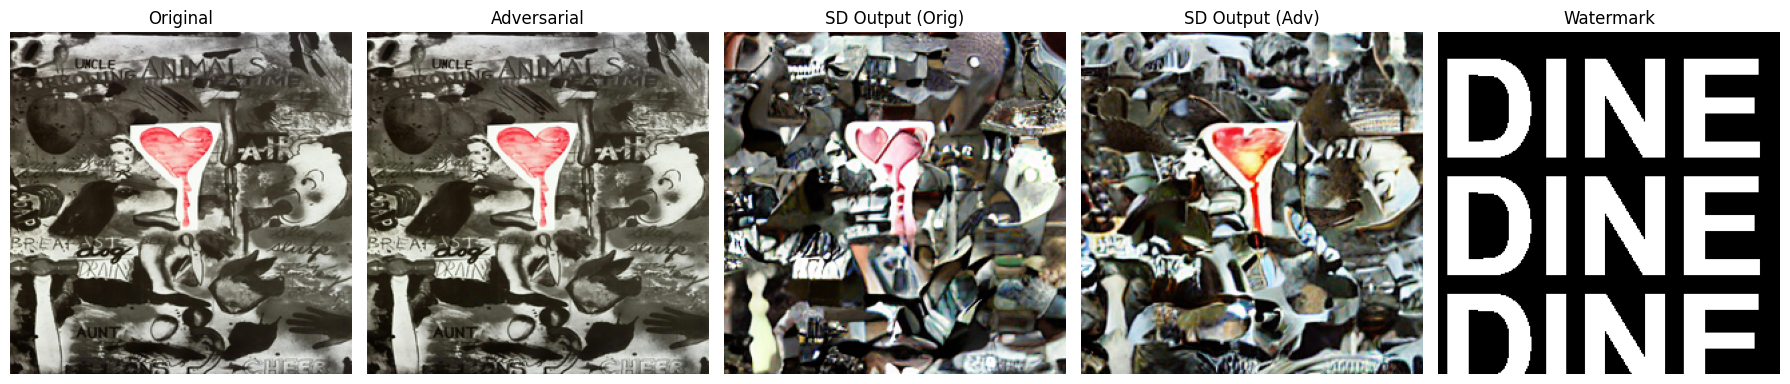

In [ ]:
import torch, numpy as np
import transformers   # import first!
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers import StableDiffusionImg2ImgPipeline
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1️⃣  Load the best generator checkpoint
G.eval()
G.load_state_dict(torch.load(f"{OUT_DIR}/generator_best.pth", map_location=DEVICE))
G = G.to(DEVICE)

# 2️⃣  Pick one validation batch
imgs, wms, paths = next(iter(val_loader))
imgs, wms = imgs.to(DEVICE), wms.to(DEVICE)
perturb = G(imgs, wms)
adv = torch.clamp(imgs + perturb * PERT_BOUND * 200, 0.0, 1.0)

# Save originals & adversarials
save_image(imgs, f"{OUT_DIR}/orig_samples.png", nrow=4)
save_image(adv,  f"{OUT_DIR}/adv_samples.png",  nrow=4)
print("✅ Saved orig_samples.png and adv_samples.png")

# 3️⃣  Load Stable Diffusion 1.5 img2img pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

pipe.enable_attention_slicing()

# 4️⃣  Convert one pair to PIL
def to_pil(t):
    x = (t.detach().clamp(0,1).permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
    return Image.fromarray(x)

img_orig = to_pil(imgs[3])
img_adv  = to_pil(adv[3])

prompt = "a painting"

gen_orig = pipe(prompt=prompt, image=img_orig, strength=0.2, guidance_scale=2, num_inference_steps=100).images[0]
gen_adv  = pipe(prompt=prompt, image=img_adv,  strength=0.2, guidance_scale=2, num_inference_steps=100).images[0]

gen_orig.save(f"{OUT_DIR}/gen_from_orig.png")
gen_adv.save(f"{OUT_DIR}/gen_from_adv.png")
print("🖼️  Generated diffusion outputs saved.")

# 5️⃣  Compute Normalized Cross-Correlation (NCC) between generation & watermark
def ncc(a,b):
    a = a - a.mean(); b = b - b.mean()
    return float((a*b).sum() / (np.sqrt((a*a).sum() * (b*b).sum()) + 1e-8))

gen_o = np.array(gen_orig.convert("L"), np.float32) / 255.0
gen_a = np.array(gen_adv.convert("L"),  np.float32) / 255.0
wm    = wms[0].squeeze().cpu().numpy()

ncc_orig = ncc(gen_o, wm)
ncc_adv  = ncc(gen_a, wm)
print(f"NCC(original→wm) = {ncc_orig:.3f}")
print(f"NCC(adversarial→wm) = {ncc_adv:.3f}")

# 6️⃣  Show all images side-by-side
fig, ax = plt.subplots(1,5, figsize=(18,4))
ax[0].imshow(img_orig); ax[0].set_title("Original")
ax[1].imshow(img_adv);  ax[1].set_title("Adversarial")
ax[2].imshow(gen_orig); ax[2].set_title("SD Output (Orig)")
ax[3].imshow(gen_adv);  ax[3].set_title("SD Output (Adv)")
ax[4].imshow(wm, cmap="gray"); ax[4].set_title("Watermark")
for a in ax: a.axis("off")
plt.tight_layout(); plt.show()
